## Classifying LoS using Machine Learning Models in MIMIC-III

### Import pandas and numpy packages

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Read in the data which is merged

The data has 58979 observations

In [2]:
data = pd.read_csv("merged_data.csv")

In [3]:
data.shape

(58976, 23)

In [4]:
data.columns

Index(['Unnamed: 0', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
       'admission_type', 'ethnicity', 'marital_status', 'diagnosis',
       'hospital_expire_flag', 'deathtime', 'gender', 'dob', 'hospital_los',
       'admit_age_yr', 'ICU_los_sum', 'ICU_times', 'icd9_code', 'num_icd',
       'short_title', 'long_title', 'abnorm_percent', 'ethnicity_adj'],
      dtype='object')

### Subset the whole dataset with variables selected

Adjust the data types for variables

In [5]:
var = ['subject_id', 'hadm_id',                                         ## identification
       'admit_age_yr','ethnicity_adj', 'gender', 'marital_status',      ## demogrphic
       'admission_type', 'diagnosis', 'hospital_expire_flag',           ## admission info / death
       'hospital_los', 'ICU_los_sum',                                   ## los
       'ICU_times', 'num_icd', 'abnorm_percent']                        ## other indicators
data = data[var]

In [6]:
data["hospital_expire_flag"] = data["hospital_expire_flag"].astype("object")

In [7]:
data.dtypes

subject_id                int64
hadm_id                   int64
admit_age_yr            float64
ethnicity_adj            object
gender                   object
marital_status           object
admission_type           object
diagnosis                object
hospital_expire_flag     object
hospital_los            float64
ICU_los_sum             float64
ICU_times               float64
num_icd                 float64
abnorm_percent          float64
dtype: object

### Drop the observations with missing datas

In [8]:
data2 = data
data2 = data2.dropna()
data2.shape

data = data2

### Exploratory Data Analysis - Categorical Data

In [9]:
print(data["ethnicity_adj"].value_counts())
print(data["gender"].value_counts())
print(data["marital_status"].value_counts())
print(data["admission_type"].value_counts())
print(len(data["diagnosis"].unique()))
print(data["hospital_expire_flag"].value_counts())

WHITE              34384
BLACK               4757
UNKNOWN             4122
HISPANIC            1687
ASIAN               1191
OTHER                996
MULTI RACE           114
PORTUGUESE            59
MIDDLE EASTERN        40
AMERICAN NATIVE       25
NATIVE HAWAIIAN       12
CARIBBEAN              9
SOUTH AMERICAN         7
Name: ethnicity_adj, dtype: int64
M    26581
F    20822
Name: gender, dtype: int64
MARRIED              23462
SINGLE               12904
WIDOWED               7008
DIVORCED              3119
SEPARATED              555
UNKNOWN (DEFAULT)      340
LIFE PARTNER            15
Name: marital_status, dtype: int64
EMERGENCY    39088
ELECTIVE      6868
URGENT        1148
NEWBORN        299
Name: admission_type, dtype: int64
14533
0    42258
1     5145
Name: hospital_expire_flag, dtype: int64


### Exploratory Data Analysis - Quantatitive Data

In [10]:
data.describe()

,subject_id,hadm_id,admit_age_yr,hospital_los,ICU_los_sum,ICU_times,num_icd,abnorm_percent
count,47403.00000,47403.000000,47403.000000,47403.000000,47403.000000,47403.000000,47403.000000,47403.000000
mean,36798.74489,149984.326730,63.495570,10.031783,4.458169,1.073371,12.046727,0.340378
std,29001.39648,28900.726103,17.841933,10.897917,6.911652,0.304143,6.481199,0.099372
min,3.00000,100001.000000,0.000000,-0.797222,0.000200,1.000000,1.000000,0.000000
25%,13329.00000,124979.000000,52.524749,4.055903,1.229750,1.000000,8.000000,0.275316
50%,26754.00000,150007.000000,65.399337,6.929861,2.202700,1.000000,10.000000,0.338645
75%,60081.50000,175065.500000,77.565263,11.947222,4.532400,1.000000,16.000000,0.404762
max,99999.00000,199999.000000,90.000000,294.618750,260.708900,7.000000,39.000000,0.777778


In [11]:
import seaborn as sns

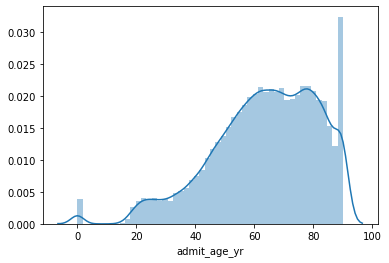

In [12]:
sns.distplot(data["admit_age_yr"])

the distribution for patients age when admitted shows the majority of patients are over 50 years old, however, for patients over 89, the data hide the actual age and replace as a higher number, we use 90 for patients over 89

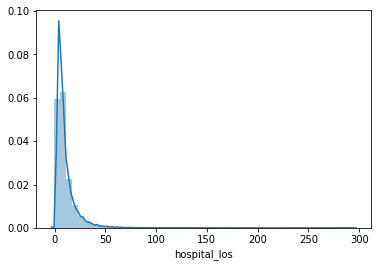

In [13]:
sns.distplot(data["hospital_los"])

most of the length stayed in the hospital are less then 50 days and highly skewed to right

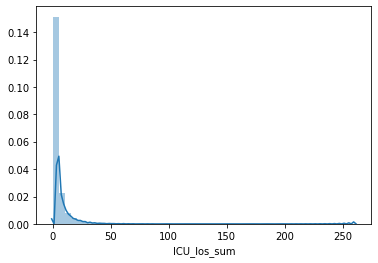

In [14]:
sns.distplot(data["ICU_los_sum"])

a calculation on total ICU stays also shows highly skewed to right and most of the patients did not went into ICU for several days

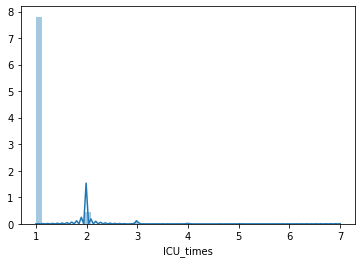

In [15]:
sns.distplot(data["ICU_times"])

Since it is a emergency system data, the total times that one patient went into ICU is counted, most are 1 times, and the highest is 7 times

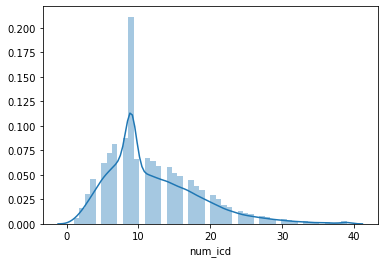

In [16]:
sns.distplot(data["num_icd"])

the patients will be diagnosised during the visit and the results will be presented by icd9 codes, we counted the number of icd9 codes for each patients, more icd9 codes for one patients means more server situation

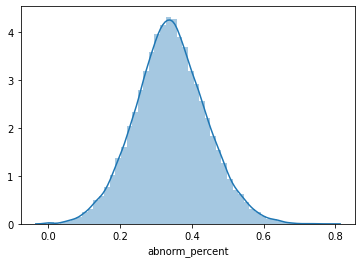

In [17]:
sns.distplot(data["abnorm_percent"])

we also calculated the adnormal lab test results for each patients in percentage, it is surprised to see that the distribution is normal and centered at around 0.38

## One-Hot Vector for Categorical Variables

Due to the machine learning methods theories, categorical variables cannot use numbers (factorization) to level. A common way to solve the problem is to use one-hot vector method. More information about how the one-hot work, can be found here: https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/

In [18]:
cat = ['ethnicity_adj', 'gender', 'marital_status', 'admission_type', "hospital_expire_flag"]  ##'diagnosis', 
cat_dummy = pd.get_dummies(data[cat])

In [19]:
numr = ['admit_age_yr', 'hospital_los', 'ICU_times', 'num_icd', "abnorm_percent"]
data_num = data[numr]

In [20]:
data_all = pd.concat([data_num, cat_dummy], axis=1)

In [21]:
data_all.head(5)

,admit_age_yr,hospital_los,ICU_times,num_icd,abnorm_percent,ethnicity_adj_AMERICAN NATIVE,ethnicity_adj_ASIAN,ethnicity_adj_BLACK,ethnicity_adj_CARIBBEAN,ethnicity_adj_HISPANIC,...,marital_status_SEPARATED,marital_status_SINGLE,marital_status_UNKNOWN (DEFAULT),marital_status_WIDOWED,admission_type_ELECTIVE,admission_type_EMERGENCY,admission_type_NEWBORN,admission_type_URGENT,hospital_expire_flag_0,hospital_expire_flag_1
0,64.838053,1.144444,1.0,7.0,0.043956,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
1,71.032952,5.496528,1.0,8.0,0.360577,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,75.151921,6.768056,1.0,10.0,0.312217,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
3,38.962888,2.856944,1.0,4.0,0.131313,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0
4,58.868319,3.534028,1.0,4.0,0.377778,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0


<hr>

since the dignosis has a total of over 10,000 unique values, it will be hard for models to run with all columns, we excluded the diagnosis at first the here is the shape

In [22]:
data_all.shape

(47403, 33)

## Separate to predictor and response

as well as train and test data

In [23]:
y_data = data_all["hospital_los"]
X = data_all.drop(columns = ["hospital_los"])

since we are classifying the LoS by 5 days, we encode the LoS by the following rules:
- if LoS is less or equal to 5, encode as 0
- if LoS is greater than 5, encode as 1

In [24]:
## <= 5 days -- 0
## > 5 days -- 1
y1 = [0 if number <= 5 else 1 for number in y_data]

#### Train and test split

In [25]:
from sklearn import datasets, model_selection as ms, metrics, cluster, linear_model as lm

In [26]:
from sklearn.model_selection import cross_val_score

In [27]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y1, test_size=0.2)

## SVM model

building the SVC (classification in SVM) with basic parameters and stanardscaler

In [28]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('svc',
                 SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma='auto',
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)

#### cross-validation

having the 5-fold cross valiation, the unbiased accuracy score is around 70%

In [44]:
scores_svc = cross_val_score(clf, X, y1, cv=5)
np.mean(scores_svc)

0.6965803625906044

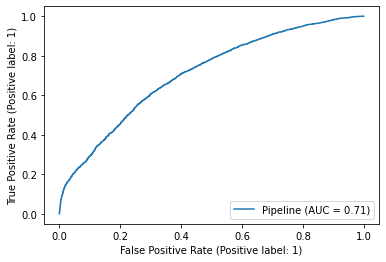

In [43]:
import matplotlib.pyplot as plt
metrics.plot_roc_curve(clf, X_test, y_test) 
plt.show()

## Random Forest Model

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
rf = RandomForestClassifier(max_depth=5, random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=5, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### cross-validation

having the 5-fold cross valiation, the unbiased accuracy score is around 70%, but lower than basic SVC

In [30]:
scores_rf = cross_val_score(rf, X, y1, cv=5)
np.mean(scores_rf)

0.6963691028514948

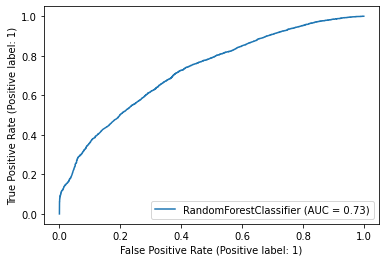

In [31]:
import matplotlib.pyplot as plt
metrics.plot_roc_curve(rf, X_test, y_test) 
plt.show()

## Tuning for RF

Having 24 pairs of candidates parameters and fit the randomforest for 120 times for the best parameter combinitions

In [32]:
from sklearn.model_selection import GridSearchCV

# defining parameter range
param_grid = {'criterion': ['gini', "entropy"],
              'max_depth': [1, 5, 10, 100],
              'max_features': ['auto', 'sqrt', 'log2']}
 
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV 1/5] END criterion=gini, max_depth=1, max_features=auto;, score=0.658 total time=   0.4s
[CV 2/5] END criterion=gini, max_depth=1, max_features=auto;, score=0.658 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=1, max_features=auto;, score=0.658 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=1, max_features=auto;, score=0.658 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=1, max_features=auto;, score=0.658 total time=   0.3s
[CV 1/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.658 total time=   0.3s
[CV 2/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.658 total time=   0.3s
[CV 3/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.658 total time=   0.3s
[CV 4/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.658 total time=   0.3s
[CV 5/5] END criterion=gini, max_depth=1, max_features=sqrt;, score=0.658 total time=   0.3s
[CV 1/5]

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [1, 5, 10, 100],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=3)

In [33]:
print(grid.best_params_)
print(grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 10, 'max_features': 'auto'}
RandomForestClassifier(max_depth=10)


the best parameters is shown above

In [34]:
grid_predictions = grid.predict(X_test)

from sklearn.metrics import classification_report
print(classification_report(y_test, grid_predictions))

              precision    recall  f1-score   support

           0       0.65      0.27      0.39      3164
           1       0.72      0.93      0.81      6317

    accuracy                           0.71      9481
   macro avg       0.69      0.60      0.60      9481
weighted avg       0.70      0.71      0.67      9481



Having the classification report (above) indicates that the accuracy for the best can be increased to 71% and the roc (below) can have a AUC = 0.74

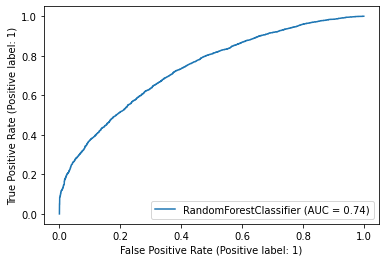

In [35]:
rf = RandomForestClassifier(max_depth=10,criterion = 'gini',max_features= 'auto')
rf.fit(X_train, y_train)
metrics.plot_roc_curve(rf, X_test, y_test) 
plt.show()

## Include diagnosis for RF

since random forest can run much faster than SVM, we added the diagnosis into the data, the final shape of the data is:
- 47403 observations
- 14566 variables

In [11]:
cat = ['ethnicity_adj', 'gender', 'marital_status', 'admission_type', 'diagnosis', "hospital_expire_flag"] 
cat_dummy1 = pd.get_dummies(data[cat])
numr = ['admit_age_yr', 'hospital_los', 'ICU_times', 'num_icd', "abnorm_percent"]
data_num1 = data[numr]
data_all1 = pd.concat([data_num1, cat_dummy1], axis=1)
data_all1.shape

(47403, 14566)

Do the same threshold for levels

In [36]:
y_data1 = data_all1["hospital_los"]
X1 = data_all1.drop(columns = ["hospital_los"])

## <= 5 days -- 0
## > 5 days -- 1
y11 = [0 if number <= 5 else 1 for number in y_data1]

split the data into train and test

In [37]:
X_train1, X_test1, y_train1, y_test1 = ms.train_test_split(X1, y11, test_size=0.2)

tuning the parameters for RF with some candidates

In [38]:
# defining parameter range
param_grid = {'criterion': ['gini', "entropy"],
              'max_depth': [2,5],
              'max_features': ['auto', 'sqrt', 'log2']}
 
grid = GridSearchCV(RandomForestClassifier(), param_grid, refit = True, verbose = 3)
grid.fit(X_train1, y_train1)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END criterion=gini, max_depth=2, max_features=auto;, score=0.661 total time=   5.6s
[CV 2/5] END criterion=gini, max_depth=2, max_features=auto;, score=0.661 total time=   5.5s
[CV 3/5] END criterion=gini, max_depth=2, max_features=auto;, score=0.661 total time=   5.6s
[CV 4/5] END criterion=gini, max_depth=2, max_features=auto;, score=0.661 total time=   5.6s
[CV 5/5] END criterion=gini, max_depth=2, max_features=auto;, score=0.661 total time=   5.4s
[CV 1/5] END criterion=gini, max_depth=2, max_features=sqrt;, score=0.661 total time=   5.6s
[CV 2/5] END criterion=gini, max_depth=2, max_features=sqrt;, score=0.661 total time=   5.5s
[CV 3/5] END criterion=gini, max_depth=2, max_features=sqrt;, score=0.661 total time=   5.6s
[CV 4/5] END criterion=gini, max_depth=2, max_features=sqrt;, score=0.661 total time=   5.4s
[CV 5/5] END criterion=gini, max_depth=2, max_features=sqrt;, score=0.661 total time=   5.6s
[CV 1/5] 

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'], 'max_depth': [2, 5],
                         'max_features': ['auto', 'sqrt', 'log2']},
             verbose=3)

since the number of columns are so large, the score is actually consistant among all combinations

In [39]:
print(grid.best_params_)
print(grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 2, 'max_features': 'auto'}
RandomForestClassifier(max_depth=2)


In [40]:
grid_predictions = grid.predict(X_test1)

from sklearn.metrics import classification_report
print(classification_report(y_test1, grid_predictions))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3284
           1       0.65      1.00      0.79      6197

    accuracy                           0.65      9481
   macro avg       0.33      0.50      0.40      9481
weighted avg       0.43      0.65      0.52      9481



A classifcation report (above) and roc plot (below) also produced with AUC = 0.71

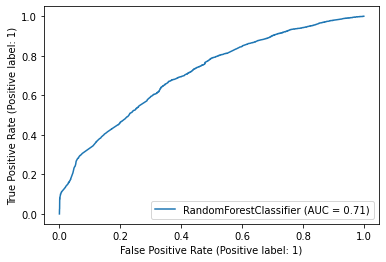

In [41]:
rf = RandomForestClassifier(max_depth=2, criterion = 'gini',max_features= 'auto')
rf.fit(X_train, y_train)
metrics.plot_roc_curve(rf, X_test, y_test) 
plt.show()

## Plotting the ROC and AUC classifcation results in one plot

In [41]:
import matplotlib.pyplot as plt

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score

# Instantiate the classfiers and make a list
classifiers = [make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True)), 
               RandomForestClassifier(max_depth=5, random_state=0), 
               RandomForestClassifier(max_depth=10,criterion = 'gini',max_features= 'auto')]

# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['classifiers', 'fpr','tpr','auc'])

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train, y_train)
    yproba = model.predict_proba(X_test)[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    result_table = result_table.append({'classifiers':cls.__class__.__name__,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc}, ignore_index=True)

# Set name of the classifiers as index labels
result_table.set_index('classifiers', inplace=True)

In [70]:
name = ["baseline_SVC", "baseline_RF", "tuned_RF"]
result_table["label"] = name

In [72]:
result_table = result_table.reset_index()

In [73]:
result_table

,classifiers,fpr,tpr,auc,label
0,Pipeline,"[0.0, 0.0, 0.0, 0.00030959752321981426, 0.0003...","[0.0, 0.00015997440409534473, 0.00575907854743...",0.712421,baseline_SVC
1,RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00015997440409534473, 0.00047992321228...",0.729292,baseline_RF
2,RandomForestClassifier,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.00047992321228603423, 0.00063989761638...",0.735981,tuned_RF


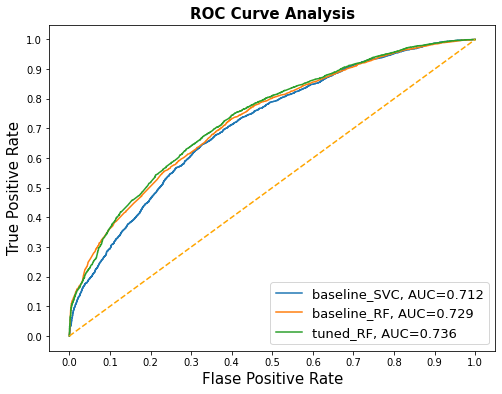

<Figure size 432x288 with 0 Axes>

In [76]:
fig = plt.figure(figsize=(8,6))

for i in range(3):
    plt.plot(result_table.iloc[i]['fpr'], 
             result_table.iloc[i]['tpr'],
             label="{}, AUC={:.3f}".format(result_table.iloc[i]["label"], result_table.iloc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("Flase Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

plt.savefig("roc.svg", format="svg")